In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd #Basic library for all of our dataset operations
import numpy as np
import requests
import io
import statsmodels.tsa.api as smt
import statsmodels as sm
import tensorflow as tf
import pmdarima as pm
import warnings
import xgboost as xgb
import plotly.express as px
import plotly.graph_objects as go

from metrics import evaluate

import lightgbm as lgb
import gluonts
from math import sqrt

import shap
warnings.filterwarnings("ignore") #We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones


from statsmodels.tsa.ar_model import AR
from random import random
from datetime import datetime
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn import linear_model, svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from math import sqrt
from xgboost import plot_importance, plot_tree
from itertools import islice
from pylab import rcParams
# progress bar
from tqdm import tqdm, tqdm_notebook
from bayes_opt import BayesianOptimization


#Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('dark_background')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

plt.style.use('dark_background')

2.3.1


## Data Preprocessing

In [2]:
df = pd.read_csv('dash_data2.csv')

In [3]:
df.head()

Unnamed: 0  Flown Date     Rute         COMMODITY  Payload  A/C ORIGIN  \
0           0  2019-01-01  SUB-SRG  PERISHABLE GOODS        1  JET    SUB   
1           1  2019-01-01  DPS-TMC  PERISHABLE GOODS        9  JET    DPS   
2           2  2019-01-01  SUB-PKN     GENERAL CARGO        5  JET    SUB   
3           3  2019-01-01  SUB-SMQ     GENERAL CARGO        2  JET    SUB   
4           4  2019-01-02  DPS-BMU     GENERAL CARGO        1  JET    DPS   

  DEST  Grand Total                       Agent Name  
0  SRG        -2354  PT SURYAGITA NUSARAYA BPN CARGO  
1  TMC      -194400                    AGA CARGO DPS  
2  PKN       -37915  PT SURYAGITA NUSARAYA SUB CARGO  
3  SMQ       -24610                 PT DBM SUB CARGO  
4  BMU       -13589  PT MANDIRI HANDALAN P SUB CARGO

In [4]:
df = df.rename(columns=
                       {'Flown Date':'flown_date',
                        'Rute':'route',
                        'COMMODITY':'commodity',
                        'Payload':'payload',
                        'A/C':'aircraft',
                        'ORIGIN':'orig',
                       'DEST':'dest',
                       'Grand Total':'total_price',
                       'Agent Name':'agent'}).drop('Unnamed: 0', axis=1)

In [5]:
df_iata = pd.read_csv('airport-codes_csv.csv')

In [6]:
df_iata = df_iata[['iata_code','name','coordinates']].dropna(axis=0).reset_index(drop=True)

In [7]:
df_iata

iata_code                         name  \
0          UTK               Utirik Airport   
1          OCA      Ocean Reef Club Airport   
2          PQS        Pilot Station Airport   
3          CSE        Crested Butte Airpark   
4          JCY            LBJ Ranch Airport   
...        ...                          ...   
9220       DLC           Zhoushuizi Airport   
9221       TNH    Tonghua Sanyuanpu Airport   
9222       SHE              Taoxian Airport   
9223       YNJ  Yanji Chaoyangchuan Airport   
9224       YKH        Yingkou Lanqi Airport   

                                 coordinates  
0                         169.852005, 11.222  
1          -80.274803161621, 25.325399398804  
2                     -162.899994, 61.934601  
3                     -106.928341, 38.851918  
4     -98.62249755859999, 30.251800537100003  
...                                      ...  
9220    121.53900146484375, 38.9656982421875  
9221            125.703333333, 42.2538888889  
9222  123.48300170898438, 41.639801025390625  
9223            129.451004028, 42.8828010559  
9224                     122.3586, 40.542524  

[9225 rows x 3 columns]

In [8]:
df_tmp_1 = df_iata.copy()

In [9]:
df_tmp_1['coordinates'] = df_iata["coordinates"].str.split(",", n=1, expand = True).astype(float)

In [10]:
df_tmp_1

iata_code                         name  coordinates
0          UTK               Utirik Airport   169.852005
1          OCA      Ocean Reef Club Airport   -80.274803
2          PQS        Pilot Station Airport  -162.899994
3          CSE        Crested Butte Airpark  -106.928341
4          JCY            LBJ Ranch Airport   -98.622498
...        ...                          ...          ...
9220       DLC           Zhoushuizi Airport   121.539001
9221       TNH    Tonghua Sanyuanpu Airport   125.703333
9222       SHE              Taoxian Airport   123.483002
9223       YNJ  Yanji Chaoyangchuan Airport   129.451004
9224       YKH        Yingkou Lanqi Airport   122.358600

[9225 rows x 3 columns]

In [11]:
df_tmp_2 = df_iata["coordinates"].str.split(",", expand = True)

In [12]:
df_tmp_2 = df_tmp_2.rename(columns={0:'longitude',1:'latitude'})

In [13]:
df_tmp_2 = df_tmp_2[['latitude','longitude']].astype(float)

In [14]:
df_tmp_2

latitude   longitude
0     11.222000  169.852005
1     25.325399  -80.274803
2     61.934601 -162.899994
3     38.851918 -106.928341
4     30.251801  -98.622498
...         ...         ...
9220  38.965698  121.539001
9221  42.253889  125.703333
9222  41.639801  123.483002
9223  42.882801  129.451004
9224  40.542524  122.358600

[9225 rows x 2 columns]

In [15]:
df_tmp_3 = pd.merge(left=df_tmp_1, right=df_tmp_2, left_on='coordinates', right_on='longitude', how='left').drop('coordinates', axis=1)

In [16]:
df_tmp_3

iata_code                         name   latitude   longitude
0          UTK               Utirik Airport  11.222000  169.852005
1          OCA      Ocean Reef Club Airport  25.325399  -80.274803
2          PQS        Pilot Station Airport  61.934601 -162.899994
3          CSE        Crested Butte Airpark  38.851918 -106.928341
4          JCY            LBJ Ranch Airport  30.251801  -98.622498
...        ...                          ...        ...         ...
9274       DLC           Zhoushuizi Airport  38.965698  121.539001
9275       TNH    Tonghua Sanyuanpu Airport  42.253889  125.703333
9276       SHE              Taoxian Airport  41.639801  123.483002
9277       YNJ  Yanji Chaoyangchuan Airport  42.882801  129.451004
9278       YKH        Yingkou Lanqi Airport  40.542524  122.358600

[9279 rows x 4 columns]

In [17]:
df = pd.merge(left=df, right=df_tmp_3, left_on='orig', right_on='iata_code', how='left')

In [18]:
df

flown_date    route         commodity  payload aircraft orig dest  \
0       2019-01-01  SUB-SRG  PERISHABLE GOODS        1      JET  SUB  SRG   
1       2019-01-01  DPS-TMC  PERISHABLE GOODS        9      JET  DPS  TMC   
2       2019-01-01  SUB-PKN     GENERAL CARGO        5      JET  SUB  PKN   
3       2019-01-01  SUB-SMQ     GENERAL CARGO        2      JET  SUB  SMQ   
4       2019-01-02  DPS-BMU     GENERAL CARGO        1      JET  DPS  BMU   
...            ...      ...               ...      ...      ...  ...  ...   
148544  2020-01-01  CGK-BUU     GENERAL CARGO      233      JET  CGK  BUU   
148545  2020-01-01  CGK-LLJ      LIVE ANIMALS       10      JET  CGK  LLJ   
148546  2019-12-31  SUB-PKN  PERISHABLE GOODS       76      JET  SUB  PKN   
148547  2020-01-02  DPS-LBJ      LIVE ANIMALS       40      JET  DPS  LBJ   
148548  2020-01-01  SUB-DPS      LIVE ANIMALS       40      JET  SUB  DPS   

        total_price                              agent iata_code  \
0             -2354    PT SURYAGITA NUSARAYA BPN CARGO       SUB   
1           -194400                      AGA CARGO DPS       DPS   
2            -37915    PT SURYAGITA NUSARAYA SUB CARGO       SUB   
3            -24610                   PT DBM SUB CARGO       SUB   
4            -13589    PT MANDIRI HANDALAN P SUB CARGO       DPS   
...             ...                                ...       ...   
148544     -1331274                   PT DBM CARGO CGK       CGK   
148545      -139904             PT DUA KAWAN ABADI JOG       CGK   
148546     -1269856  ANDALAN TOTAL TRANSPORT SUB CARGO       SUB   
148547     -1388536    PT MANDIRI HANDALAN P SUB CARGO       DPS   
148548      -792504    PT MANDIRI HANDALAN P SUB CARGO       SUB   

                                           name  latitude   longitude  
0                  Juanda International Airport  -7.37983  112.787003  
1       Ngurah Rai (Bali) International Airport  -8.74817  115.167000  
2                  Juanda International Airport  -7.37983  112.787003  
3                  Juanda International Airport  -7.37983  112.787003  
4       Ngurah Rai (Bali) International Airport  -8.74817  115.167000  
...                                         ...       ...         ...  
148544     Soekarno-Hatta International Airport  -6.12557  106.655998  
148545     Soekarno-Hatta International Airport  -6.12557  106.655998  
148546             Juanda International Airport  -7.37983  112.787003  
148547  Ngurah Rai (Bali) International Airport  -8.74817  115.167000  
148548             Juanda International Airport  -7.37983  112.787003  

[148549 rows x 13 columns]

In [19]:
df.rename(columns={
                'latitude':'lat_origin',
                'longitude':'long_origin'
})

flown_date    route         commodity  payload aircraft orig dest  \
0       2019-01-01  SUB-SRG  PERISHABLE GOODS        1      JET  SUB  SRG   
1       2019-01-01  DPS-TMC  PERISHABLE GOODS        9      JET  DPS  TMC   
2       2019-01-01  SUB-PKN     GENERAL CARGO        5      JET  SUB  PKN   
3       2019-01-01  SUB-SMQ     GENERAL CARGO        2      JET  SUB  SMQ   
4       2019-01-02  DPS-BMU     GENERAL CARGO        1      JET  DPS  BMU   
...            ...      ...               ...      ...      ...  ...  ...   
148544  2020-01-01  CGK-BUU     GENERAL CARGO      233      JET  CGK  BUU   
148545  2020-01-01  CGK-LLJ      LIVE ANIMALS       10      JET  CGK  LLJ   
148546  2019-12-31  SUB-PKN  PERISHABLE GOODS       76      JET  SUB  PKN   
148547  2020-01-02  DPS-LBJ      LIVE ANIMALS       40      JET  DPS  LBJ   
148548  2020-01-01  SUB-DPS      LIVE ANIMALS       40      JET  SUB  DPS   

        total_price                              agent iata_code  \
0             -2354    PT SURYAGITA NUSARAYA BPN CARGO       SUB   
1           -194400                      AGA CARGO DPS       DPS   
2            -37915    PT SURYAGITA NUSARAYA SUB CARGO       SUB   
3            -24610                   PT DBM SUB CARGO       SUB   
4            -13589    PT MANDIRI HANDALAN P SUB CARGO       DPS   
...             ...                                ...       ...   
148544     -1331274                   PT DBM CARGO CGK       CGK   
148545      -139904             PT DUA KAWAN ABADI JOG       CGK   
148546     -1269856  ANDALAN TOTAL TRANSPORT SUB CARGO       SUB   
148547     -1388536    PT MANDIRI HANDALAN P SUB CARGO       DPS   
148548      -792504    PT MANDIRI HANDALAN P SUB CARGO       SUB   

                                           name  lat_origin  long_origin  
0                  Juanda International Airport    -7.37983   112.787003  
1       Ngurah Rai (Bali) International Airport    -8.74817   115.167000  
2                  Juanda International Airport    -7.37983   112.787003  
3                  Juanda International Airport    -7.37983   112.787003  
4       Ngurah Rai (Bali) International Airport    -8.74817   115.167000  
...                                         ...         ...          ...  
148544     Soekarno-Hatta International Airport    -6.12557   106.655998  
148545     Soekarno-Hatta International Airport    -6.12557   106.655998  
148546             Juanda International Airport    -7.37983   112.787003  
148547  Ngurah Rai (Bali) International Airport    -8.74817   115.167000  
148548             Juanda International Airport    -7.37983   112.787003  

[148549 rows x 13 columns]

In [20]:
df = pd.merge(left=df, right=df_tmp_3, left_on='dest', right_on='iata_code', how='left')

In [21]:
df

flown_date    route         commodity  payload aircraft orig dest  \
0       2019-01-01  SUB-SRG  PERISHABLE GOODS        1      JET  SUB  SRG   
1       2019-01-01  DPS-TMC  PERISHABLE GOODS        9      JET  DPS  TMC   
2       2019-01-01  SUB-PKN     GENERAL CARGO        5      JET  SUB  PKN   
3       2019-01-01  SUB-SMQ     GENERAL CARGO        2      JET  SUB  SMQ   
4       2019-01-02  DPS-BMU     GENERAL CARGO        1      JET  DPS  BMU   
...            ...      ...               ...      ...      ...  ...  ...   
150109  2020-01-01  CGK-LLJ      LIVE ANIMALS       10      JET  CGK  LLJ   
150110  2020-01-01  CGK-LLJ      LIVE ANIMALS       10      JET  CGK  LLJ   
150111  2019-12-31  SUB-PKN  PERISHABLE GOODS       76      JET  SUB  PKN   
150112  2020-01-02  DPS-LBJ      LIVE ANIMALS       40      JET  DPS  LBJ   
150113  2020-01-01  SUB-DPS      LIVE ANIMALS       40      JET  SUB  DPS   

        total_price                              agent iata_code_x  \
0             -2354    PT SURYAGITA NUSARAYA BPN CARGO         SUB   
1           -194400                      AGA CARGO DPS         DPS   
2            -37915    PT SURYAGITA NUSARAYA SUB CARGO         SUB   
3            -24610                   PT DBM SUB CARGO         SUB   
4            -13589    PT MANDIRI HANDALAN P SUB CARGO         DPS   
...             ...                                ...         ...   
150109      -139904             PT DUA KAWAN ABADI JOG         CGK   
150110      -139904             PT DUA KAWAN ABADI JOG         CGK   
150111     -1269856  ANDALAN TOTAL TRANSPORT SUB CARGO         SUB   
150112     -1388536    PT MANDIRI HANDALAN P SUB CARGO         DPS   
150113      -792504    PT MANDIRI HANDALAN P SUB CARGO         SUB   

                                         name_x  latitude_x  longitude_x  \
0                  Juanda International Airport    -7.37983   112.787003   
1       Ngurah Rai (Bali) International Airport    -8.74817   115.167000   
2                  Juanda International Airport    -7.37983   112.787003   
3                  Juanda International Airport    -7.37983   112.787003   
4       Ngurah Rai (Bali) International Airport    -8.74817   115.167000   
...                                         ...         ...          ...   
150109     Soekarno-Hatta International Airport    -6.12557   106.655998   
150110     Soekarno-Hatta International Airport    -6.12557   106.655998   
150111             Juanda International Airport    -7.37983   112.787003   
150112  Ngurah Rai (Bali) International Airport    -8.74817   115.167000   
150113             Juanda International Airport    -7.37983   112.787003   

       iata_code_y                                   name_y  latitude_y  \
0              SRG                      Achmad Yani Airport   -6.972730   
1              TMC                        Tambolaka Airport   -9.409720   
2              PKN                         Iskandar Airport   -2.705200   
3              SMQ                    Sampit(Hasan) Airport   -2.501389   
4              BMU              Muhammad Salahuddin Airport   -8.539650   
...            ...                                      ...         ...   
150109         LLJ                      Lalmonirhat Airport   25.887501   
150110         LLJ                        Silampari Airport   -3.277750   
150111         PKN                         Iskandar Airport   -2.705200   
150112         LBJ                           Komodo Airport   -8.486660   
150113         DPS  Ngurah Rai (Bali) International Airport   -8.748170   

        longitude_y  
0        110.375000  
1        119.244003  
2        111.672997  
3        112.975555  
4        118.686996  
...             ...  
150109    89.433098  
150110   102.901001  
150111   111.672997  
150112   119.889000  
150113   115.167000  

[150114 rows x 17 columns]

In [22]:
df = df.rename(columns={
    'iata_code_x':'iata_code_orig',
    'name_x':'orig_airport',
    'latitude_x':'orig_lat',
    'longitude_x':'orig_long',
    'iata_code_y':'iata_code_dest',
    'name_y':'dest_airport',
    'latitude_y':'dest_lat',
    'longitude_y':'dest_long'
})

In [23]:
df

flown_date    route         commodity  payload aircraft orig dest  \
0       2019-01-01  SUB-SRG  PERISHABLE GOODS        1      JET  SUB  SRG   
1       2019-01-01  DPS-TMC  PERISHABLE GOODS        9      JET  DPS  TMC   
2       2019-01-01  SUB-PKN     GENERAL CARGO        5      JET  SUB  PKN   
3       2019-01-01  SUB-SMQ     GENERAL CARGO        2      JET  SUB  SMQ   
4       2019-01-02  DPS-BMU     GENERAL CARGO        1      JET  DPS  BMU   
...            ...      ...               ...      ...      ...  ...  ...   
150109  2020-01-01  CGK-LLJ      LIVE ANIMALS       10      JET  CGK  LLJ   
150110  2020-01-01  CGK-LLJ      LIVE ANIMALS       10      JET  CGK  LLJ   
150111  2019-12-31  SUB-PKN  PERISHABLE GOODS       76      JET  SUB  PKN   
150112  2020-01-02  DPS-LBJ      LIVE ANIMALS       40      JET  DPS  LBJ   
150113  2020-01-01  SUB-DPS      LIVE ANIMALS       40      JET  SUB  DPS   

        total_price                              agent iata_code_orig  \
0             -2354    PT SURYAGITA NUSARAYA BPN CARGO            SUB   
1           -194400                      AGA CARGO DPS            DPS   
2            -37915    PT SURYAGITA NUSARAYA SUB CARGO            SUB   
3            -24610                   PT DBM SUB CARGO            SUB   
4            -13589    PT MANDIRI HANDALAN P SUB CARGO            DPS   
...             ...                                ...            ...   
150109      -139904             PT DUA KAWAN ABADI JOG            CGK   
150110      -139904             PT DUA KAWAN ABADI JOG            CGK   
150111     -1269856  ANDALAN TOTAL TRANSPORT SUB CARGO            SUB   
150112     -1388536    PT MANDIRI HANDALAN P SUB CARGO            DPS   
150113      -792504    PT MANDIRI HANDALAN P SUB CARGO            SUB   

                                   orig_airport  orig_lat   orig_long  \
0                  Juanda International Airport  -7.37983  112.787003   
1       Ngurah Rai (Bali) International Airport  -8.74817  115.167000   
2                  Juanda International Airport  -7.37983  112.787003   
3                  Juanda International Airport  -7.37983  112.787003   
4       Ngurah Rai (Bali) International Airport  -8.74817  115.167000   
...                                         ...       ...         ...   
150109     Soekarno-Hatta International Airport  -6.12557  106.655998   
150110     Soekarno-Hatta International Airport  -6.12557  106.655998   
150111             Juanda International Airport  -7.37983  112.787003   
150112  Ngurah Rai (Bali) International Airport  -8.74817  115.167000   
150113             Juanda International Airport  -7.37983  112.787003   

       iata_code_dest                             dest_airport   dest_lat  \
0                 SRG                      Achmad Yani Airport  -6.972730   
1                 TMC                        Tambolaka Airport  -9.409720   
2                 PKN                         Iskandar Airport  -2.705200   
3                 SMQ                    Sampit(Hasan) Airport  -2.501389   
4                 BMU              Muhammad Salahuddin Airport  -8.539650   
...               ...                                      ...        ...   
150109            LLJ                      Lalmonirhat Airport  25.887501   
150110            LLJ                        Silampari Airport  -3.277750   
150111            PKN                         Iskandar Airport  -2.705200   
150112            LBJ                           Komodo Airport  -8.486660   
150113            DPS  Ngurah Rai (Bali) International Airport  -8.748170   

         dest_long  
0       110.375000  
1       119.244003  
2       111.672997  
3       112.975555  
4       118.686996  
...            ...  
150109   89.433098  
150110  102.901001  
150111  111.672997  
150112  119.889000  
150113  115.167000  

[150114 rows x 17 columns]

In [24]:
df = pd.read_csv('dash_data_new_2.csv', parse_dates=['flown_date'])

In [25]:
df.head()

flown_date    route         commodity  payload aircraft orig dest  \
0 2019-01-01  SUB-SRG  PERISHABLE GOODS        1      JET  SUB  SRG   
1 2019-01-01  DPS-TMC  PERISHABLE GOODS        9      JET  DPS  TMC   
2 2019-01-01  SUB-PKN     GENERAL CARGO        5      JET  SUB  PKN   
3 2019-01-01  SUB-SMQ     GENERAL CARGO        2      JET  SUB  SMQ   
4 2019-01-02  DPS-BMU     GENERAL CARGO        1      JET  DPS  BMU   

   total_price                            agent iata_code_orig  \
0         2354  PT SURYAGITA NUSARAYA BPN CARGO            SUB   
1       194400                    AGA CARGO DPS            DPS   
2        37915  PT SURYAGITA NUSARAYA SUB CARGO            SUB   
3        24610                 PT DBM SUB CARGO            SUB   
4        13589  PT MANDIRI HANDALAN P SUB CARGO            DPS   

                              orig_airport  orig_lat   orig_long  \
0             Juanda International Airport  -7.37983  112.787003   
1  Ngurah Rai (Bali) International Airport  -8.74817  115.167000   
2             Juanda International Airport  -7.37983  112.787003   
3             Juanda International Airport  -7.37983  112.787003   
4  Ngurah Rai (Bali) International Airport  -8.74817  115.167000   

  iata_code_dest                 dest_airport  dest_lat   dest_long  year  \
0            SRG          Achmad Yani Airport -6.972730  110.375000  2019   
1            TMC            Tambolaka Airport -9.409720  119.244003  2019   
2            PKN             Iskandar Airport -2.705200  111.672997  2019   
3            SMQ        Sampit(Hasan) Airport -2.501389  112.975555  2019   
4            BMU  Muhammad Salahuddin Airport -8.539650  118.686996  2019   

   day month_name  
0    1        Jan  
1    1        Jan  
2    1        Jan  
3    1        Jan  
4    2        Jan

In [26]:
a = '#38BEC9'
b = '#D64545'

## EDA

In [27]:
fig = go.Figure(
    data=[
        go.Scatter(name='payload', 
               x=df.groupby('flown_date', sort=True, as_index=False).sum()['flown_date'], 
               y=df.groupby('flown_date', sort=True, as_index=False).sum()['payload'], 
               yaxis='y', 
               marker_color=b),

    ],
    layout={
        'yaxis': {'title': 'Payload'},
    }
)

# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

In [28]:
fig = go.Figure(
    data=[
        go.Scatter(name='payload', 
               x=df.groupby('month_name', sort=False, as_index=False).sum()['month_name'], 
               y=df.groupby('month_name', sort=False, as_index=False).sum()['payload'], 
               yaxis='y', 
              marker_color='#38BEC9'),
        go.Scatter(name='sales', 
               x=df.groupby('month_name', sort=False, as_index=False).sum()['month_name'], 
               y=df.groupby('month_name', sort=False, as_index=False).sum()['total_price'], 
               yaxis='y2', 
              marker_color='#D64545')
    ],
    layout={
        'yaxis': {'title': 'Payload'},
        'yaxis2': {'title': 'Sales', 'overlaying': 'y', 'side': 'right'}
    }
)

# Change the bar mode
fig.update_layout(barmode='group', 
                  bargroupgap=0.1,
                 title='Cargo Payload and Sales')
fig.show()

In [29]:
fig = go.Figure(
    data=[
        go.Bar(name='payload', 
               x=df.groupby('agent').sum().sort_values(by='payload', ascending=False).reset_index().head(10)['agent'], 
               y=df.groupby('agent').sum().sort_values(by='payload', ascending=False).reset_index().head(10)['payload'], 
               yaxis='y', 
               marker_color=b),

    ],
    layout={
        'yaxis': {'title': 'Payload'},
    }
)

# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

In [30]:
fig = go.Figure(
    data=[
        go.Bar(name='payload', 
               x=df.groupby('commodity').sum().sort_values(by='payload', ascending=False).reset_index().head(10)['commodity'], 
               y=df.groupby('commodity').sum().sort_values(by='payload', ascending=False).reset_index().head(10)['payload'], 
               yaxis='y', 
               offsetgroup=1,
               marker_color=a),
        go.Bar(name='sales', 
               x=df.groupby('commodity').sum().sort_values(by='total_price', ascending=False).reset_index().head(10)['commodity'], 
               y=df.groupby('commodity').sum().sort_values(by='total_price', ascending=False).reset_index().head(10)['total_price'], 
               yaxis='y2', 
               offsetgroup=2,
               marker_color=b),

    ],
    layout={
        'yaxis': {'title': 'Payload'},
        'yaxis2': {'title': 'Sales', 'overlaying': 'y', 'side': 'right'}
    }
)

# Change the bar mode
fig.update_layout(barmode='group', bargroupgap=0.1)
fig.show()

In [31]:
fig = go.Figure(
    data=[
        go.Scatter(name='payload', 
               x=df.groupby('day', sort=True, as_index=False).sum()['day'], 
               y=df.groupby('day', sort=False, as_index=False).sum()['payload'], 
               yaxis='y', 
              marker_color='#38BEC9'),
        go.Scatter(name='sales', 
               x=df.groupby('day', sort=True, as_index=False).sum()['day'], 
               y=df.groupby('day', sort=False, as_index=False).sum()['total_price'], 
               yaxis='y2', 
              marker_color='#D64545')
    ],
    layout={
        'yaxis': {'title': 'Payload'},
        'yaxis2': {'title': 'Sales', 'overlaying': 'y', 'side': 'right'},
        'xaxis' : {'title':'Month', 'tickmode':'linear'}
    }
)

# Change the bar mode
fig.update_layout(barmode='group', 
                  bargroupgap=0.1,
                 title='Cargo Payload and Sales')
fig.show()

In [32]:
import plotly.graph_objects as go

labels = df.groupby('commodity').sum().sort_values(by='payload', ascending=False).reset_index().head(10)['commodity']
values = df.groupby('commodity').sum().sort_values(by='payload', ascending=False).reset_index().head(10)['payload']

fig = go.Figure(data=[go.Pie(labels=labels, 
                             values=values, 
                             textinfo='label+percent',
                             insidetextorientation='radial'
                            )])
fig.show()

In [33]:
df_orig_airport = df[['orig_airport','payload','orig_lat','orig_long']].groupby('orig_airport').agg({'payload':'sum','orig_lat':'first','orig_long':'first'}).sort_values('payload', ascending=False)

In [34]:
fig = px.scatter_mapbox(df_orig_airport, 
                        lat="orig_lat", 
                        lon="orig_long", 
                        color="payload", 
                        mapbox_style='open-street-map', 
                        size='payload', 
                        text='payload',
                        color_continuous_scale=px.colors.cyclical.IceFire, 
                        zoom=3,
                        width=900,
                        height=600)

fig.update_traces(mode='markers', selector=dict(type='scattermapbox'))
# fig.update_traces(hoverlabel=dict(font='Arial'), selector=dict(type='scattermapbox'))

fig.show()

In [35]:
df_dest_airport = df[['dest_airport','payload','dest_lat','dest_long']].groupby('dest_airport').agg({'payload':'sum','dest_lat':'first','dest_long':'first'}).sort_values('payload', ascending=False)

In [36]:
fig = px.scatter_mapbox(df_dest_airport, 
                        lat="dest_lat", 
                        lon="dest_long", 
                        color="payload", 
                        mapbox_style='open-street-map', 
                        size='payload', 
                        text='payload',
                        color_continuous_scale=px.colors.cyclical.IceFire, 
                        zoom=3,
                        width=900,
                        height=600)

fig.update_traces(mode='markers', selector=dict(type='scattermapbox'))
# fig.update_traces(hoverlabel=dict(font='Arial'), selector=dict(type='scattermapbox'))

fig.show()

## Payload Forecasting

In [37]:
df_tmp = df[['flown_date','payload']].copy().groupby('flown_date', as_index=True).sum()

In [38]:
df_tmp

payload
flown_date         
2019-01-01     3667
2019-01-02     9438
2019-01-03    21422
2019-01-04    28581
2019-01-05    30519
...             ...
2019-12-27    24117
2019-12-28    24239
2019-12-29    22079
2019-12-30    13529
2019-12-31    19488

[365 rows x 1 columns]

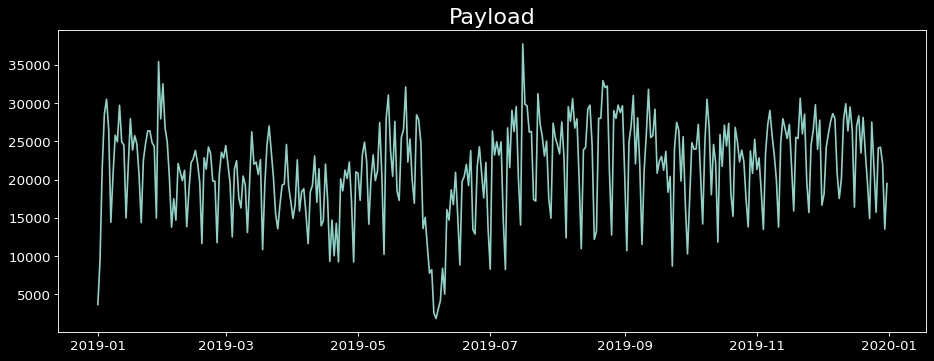

In [39]:
plt.style.use('dark_background')
plt.figure(num=None, figsize=(14, 5), dpi=80, facecolor='black', edgecolor='white')
plt.title('Payload',fontsize=20, color='white')

plt.plot(df_tmp.payload)
pass

<Figure size 4000x1600 with 0 Axes>

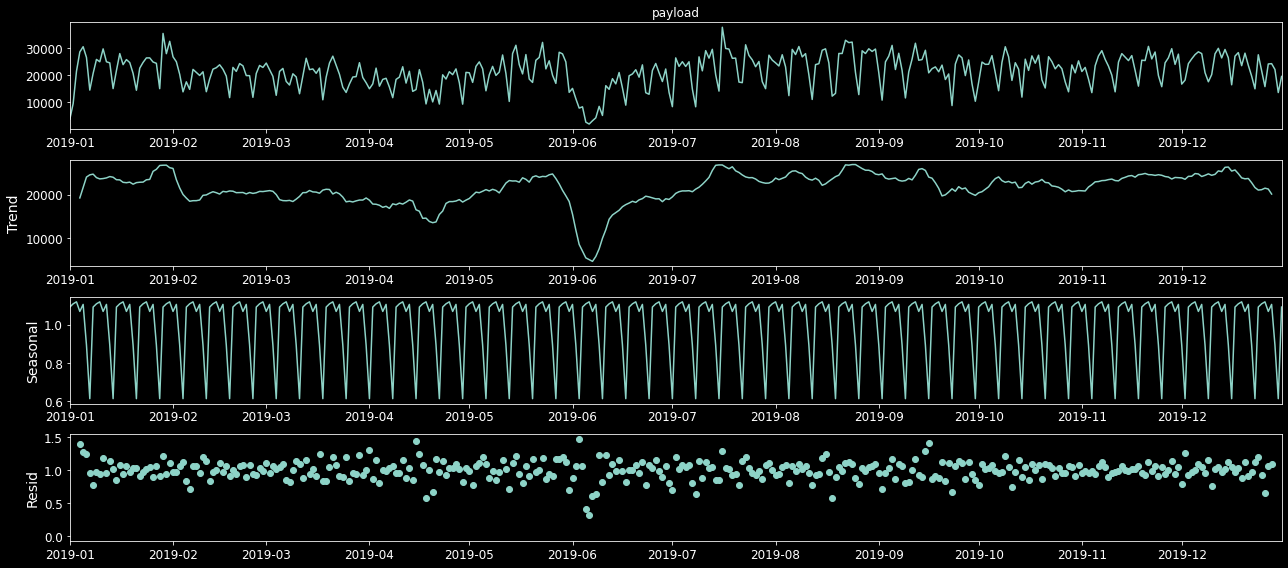

In [40]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='k', edgecolor='k')
series = df_tmp.payload
result = seasonal_decompose(series, model='multiplicative')
result.plot()
pass

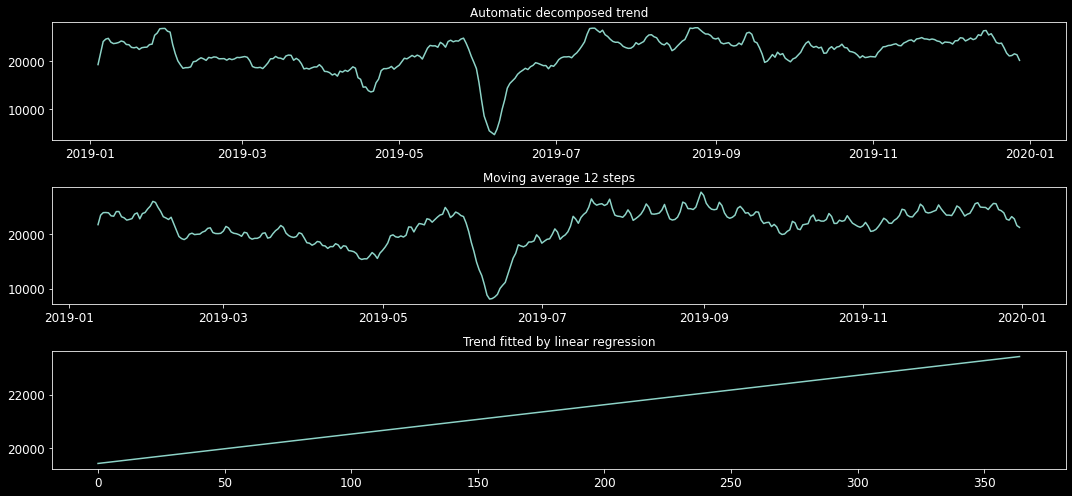

In [41]:
fig = plt.figure(figsize=(15, 7))
layout = (3,2)
pm_ax = plt.subplot2grid(layout, (0,0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1,0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2,0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = df_tmp.payload.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(df_tmp.payload))]
X = np.reshape(X, (len(X), 1))
y = df_tmp.payload.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

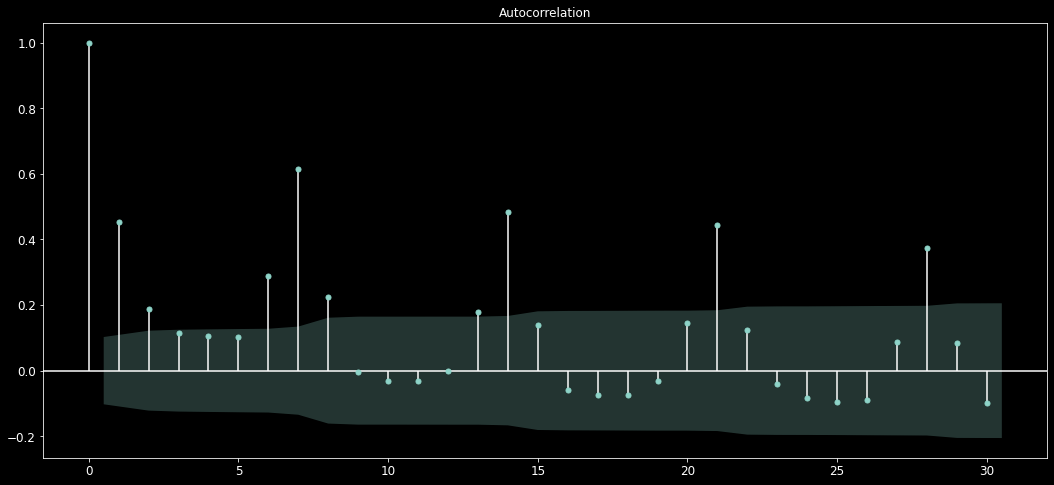

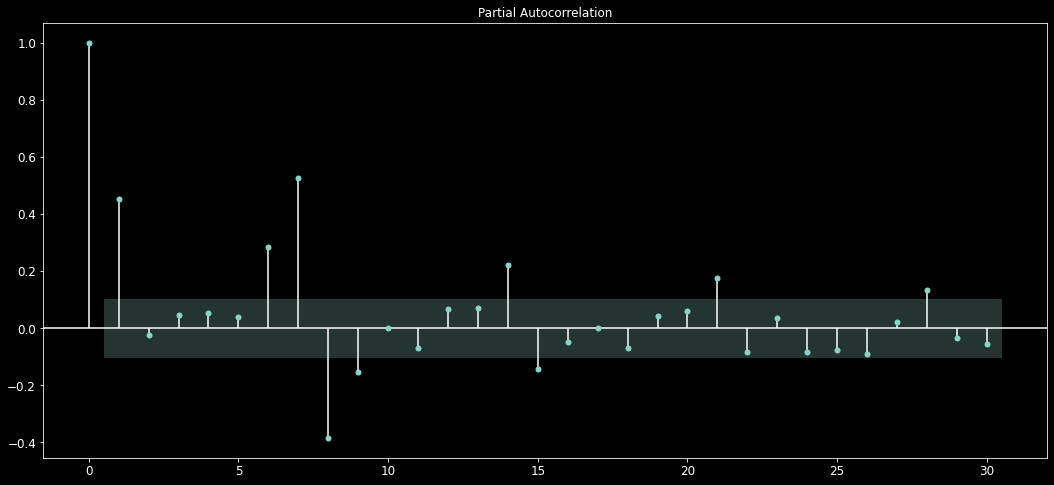

In [42]:
plot_acf(series, lags = 30)
plot_pacf(series, lags = 30)
plt.show()

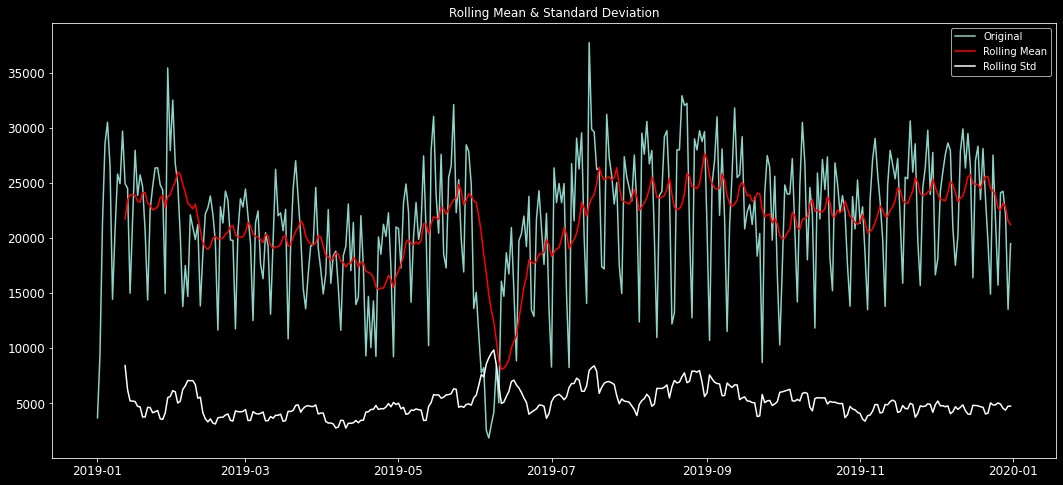

In [43]:
#Determing rolling statistics
rolmean = df_tmp.payload.rolling(window=12).mean()
rolstd = df_tmp.payload.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(df_tmp.payload,label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='white', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [44]:
X = df_tmp.payload.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.206565
p-value: 0.019608
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


H0 = data is non stationary

H1 = data is stationary

our p-value is lower than 0.05 so we can reject null hypotesis - our data is stationary

Text(0.5, 1.0, 'Original vs Windowed mean vs Windowed std')

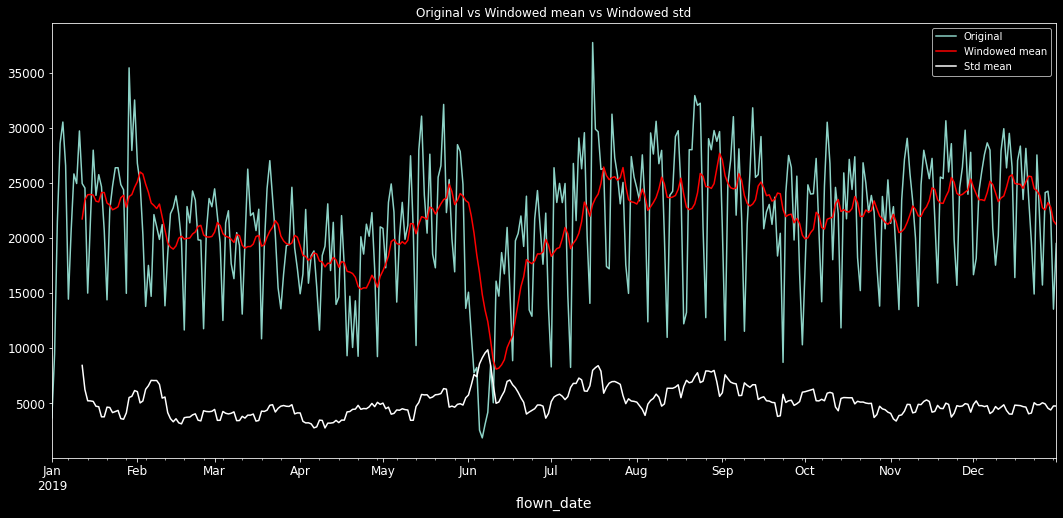

In [45]:
df_tmp.payload.plot(label='Original')
df_tmp.payload.rolling(window=12).mean().plot(color='red', label='Windowed mean')
df_tmp.payload.rolling(window=12).std().plot(color='white', label='Std mean')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')
plt.title('Original vs Windowed mean vs Windowed std', color='white')

### Univariate

In [46]:
resultsDict={}
predictionsDict={}

split_date ='2019-10-01'
df_training = df_tmp.loc[df_tmp.index <= split_date]
df_test = df_tmp.loc[df_tmp.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

df_training.to_csv('training.csv')
df_test.to_csv('test.csv')

274 days of training data 
 91 days of testing data 


### Simple Exponential Smoothing

In [47]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.payload))):
    temp_train = df_tmp[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train.payload)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test.payload, yhat.values)
predictionsDict['SES'] = yhat.values

100%|██████████| 91/91 [00:01<00:00, 79.31it/s]


[None, None, None, None]

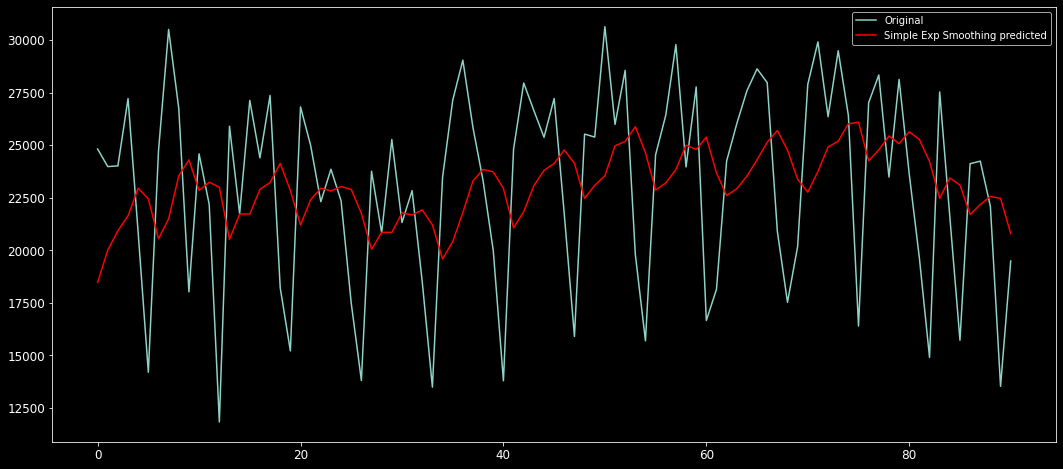

In [48]:
plt.plot(df_test.payload.values, label='Original')
plt.plot(yhat.values,color='red',label='Simple Exp Smoothing predicted')
legend = plt.legend()
plt.style.use('dark_background')
plt.setp(legend.get_texts(), color='w')

### Exponential Smoothing

In [49]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.payload))):
    temp_train = df_tmp[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train.payload)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test.payload, yhat.values)
predictionsDict['HWES'] = yhat.values

100%|██████████| 91/91 [00:01<00:00, 81.44it/s]


[None, None, None, None]

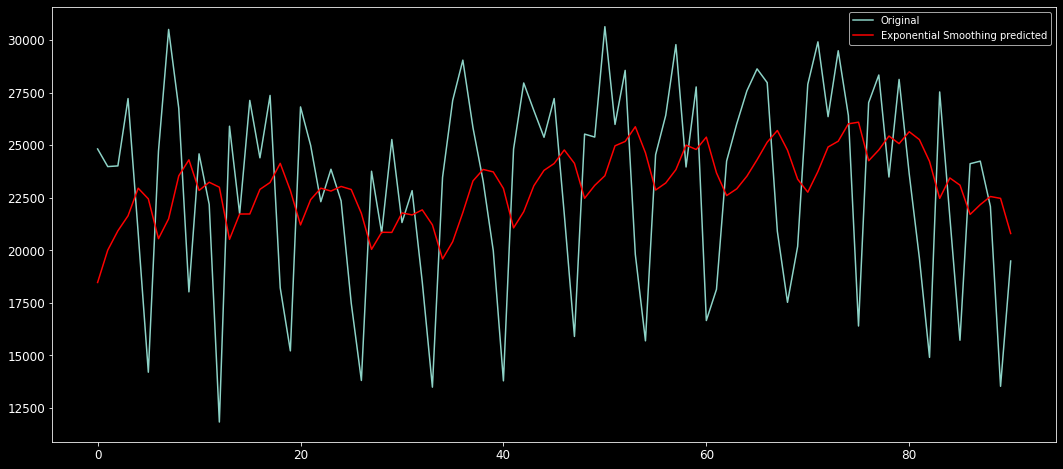

In [50]:
plt.plot(df_test.payload.values, label='Original')
plt.plot(yhat.values,color='red',label='Exponential Smoothing predicted')
legend = plt.legend()
plt.style.use('dark_background')
plt.setp(legend.get_texts(), color='w')

### AR

In [52]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.payload))):
    temp_train = df_tmp[:len(df_training)+t]
    model = AR(temp_train.payload)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test.payload, yhat.values)
predictionsDict['AR'] = yhat.values

100%|██████████| 91/91 [00:00<00:00, 266.22it/s]


[None, None, None, None]

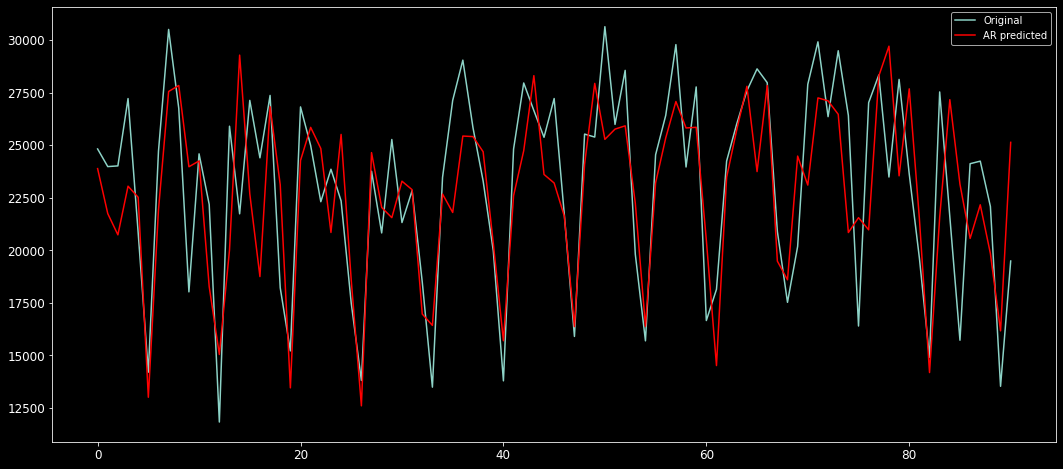

In [53]:
plt.plot(df_test.payload.values, label='Original')
plt.plot(yhat.values,color='red',label='AR predicted')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

### MA

In [54]:
from statsmodels.tsa.arima_model import ARMA
from random import random

index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.payload))):
    temp_train = df_tmp[:len(df_training)+t]
    model = ARMA(temp_train.payload, order=(0, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['MA'] = evaluate(df_test.payload, yhat.values)
predictionsDict['MA'] = yhat.values

100%|██████████| 91/91 [00:03<00:00, 24.98it/s]


[None, None, None, None]

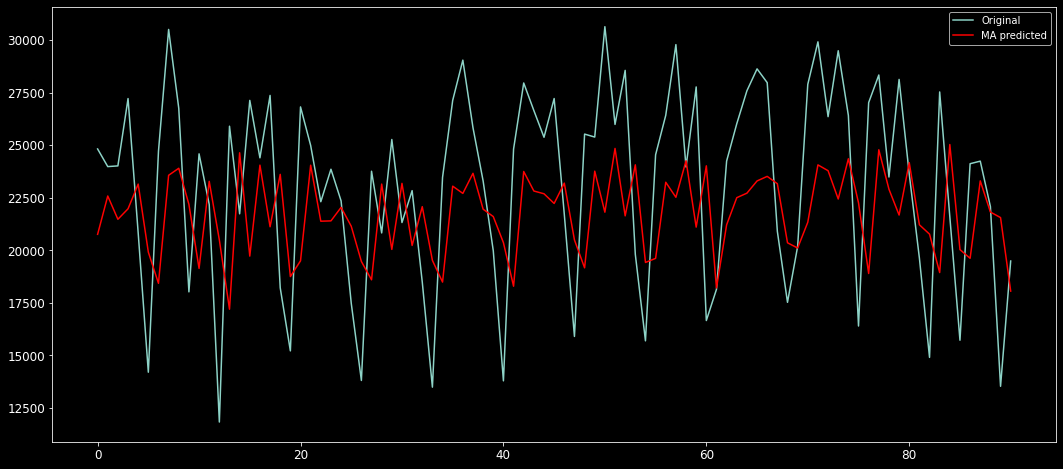

In [55]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat.values,color='red',label='MA predicted')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

### ARMA

In [56]:
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.payload))):
    temp_train = df_tmp[:len(df_training)+t]
    model = ARMA(temp_train.payload, order=(1, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['ARMA'] = evaluate(df_test.payload, yhat.values)
predictionsDict['ARMA'] = yhat.values

100%|██████████| 91/91 [00:12<00:00,  7.20it/s]


[None, None, None, None]

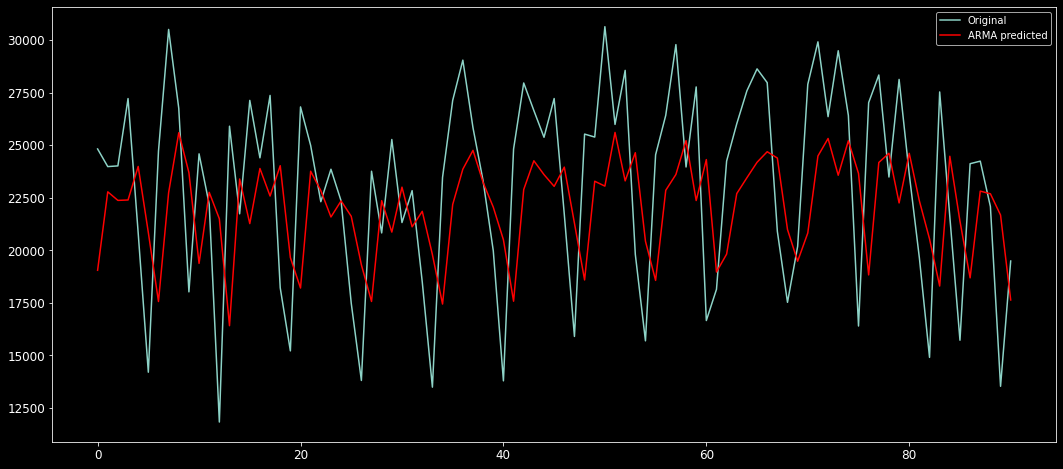

In [57]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat.values,color='red',label='ARMA predicted')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

### ARIMA

In [58]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.payload))):
    temp_train = df_tmp[:len(df_training)+t]
    model = ARIMA(temp_train.payload, order=(1,0, 0))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.payload, yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 91/91 [00:06<00:00, 13.03it/s]


[None, None, None, None]

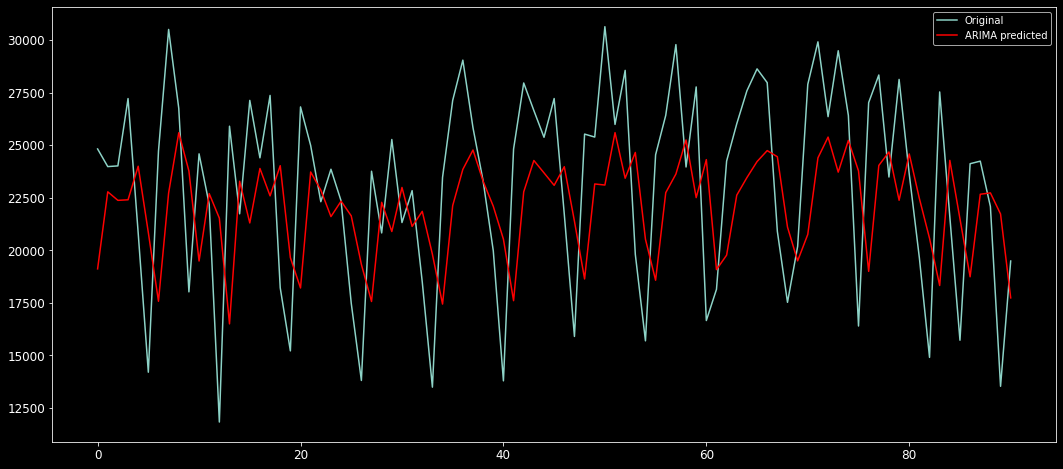

In [59]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat.values,color='red',label='ARIMA predicted')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

### AutoSARIMA

In [60]:
autoModel = pm.auto_arima(df_training.payload, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=7, stepwise=True)
autoModel.fit(df_training.payload)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5569.962, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5370.395, Time=0.41 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5442.603, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5567.980, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=5552.763, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=5350.152, Time=0.93 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=5365.919, Time=1.30 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=5334.576, Time=0.96 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=5470.150, Time=0.10 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=5362.329, Time=1.25 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=5445.916, Time=0.19 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=5345.010, Time=0.65 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=5

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(1, 0, 2, 7),
      suppress_warnings=True, with_intercept=False)

In [61]:
import statsmodels.api as sm
sm.tsa.statespace.SARIMAX

order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(df_test.payload))):
    temp_train = df_tmp[:len(df_training)+t]
    model = sm.tsa.statespace.SARIMAX(temp_train.payload, order=order, seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoSARIMA {0},{1}'.format(order,seasonalOrder)] = evaluate(df_test.payload, yhat.values)
predictionsDict['AutoSARIMA {0},{1}'.format(order,seasonalOrder)] = yhat.values

100%|██████████| 91/91 [01:48<00:00,  1.19s/it]


[None, None, None, None]

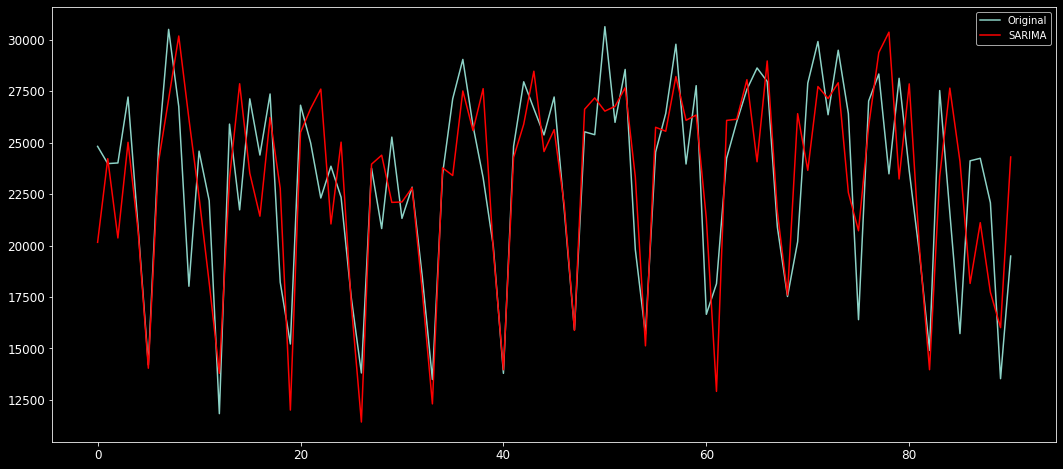

In [62]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat.values,color='red',label='SARIMA')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

### Prophet

In [63]:
prophet_training = df_training.rename(columns={'payload': 'y'})
prophet_training['ds'] = prophet_training.index
prophet_training.index = pd.RangeIndex(len(prophet_training.index))

prophet_test = df_test.rename(columns={'payload': 'y'})
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [64]:
prophet = Prophet(
    growth='linear', 
    seasonality_mode='additive',
#     holidays_prior_scale=20, 
    daily_seasonality=False, 
    weekly_seasonality=True, 
    yearly_seasonality=False
    )

In [65]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet univariate'] = evaluate(df_test.payload, yhat.yhat.values)
predictionsDict['Prophet univariate'] = yhat.yhat.values

[None, None, None, None]

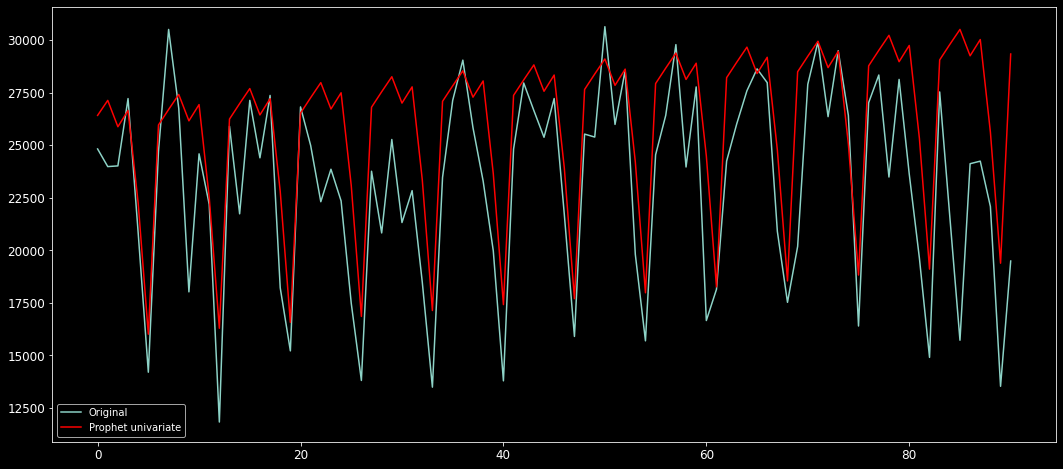

In [66]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat.yhat,color='red',label='Prophet univariate')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

In [67]:
dff = df_tmp.copy()

### Multivariate

In [68]:
def create_time_features(dff,target=None):
    """
    Creates time series features from datetime index
    """
    dff['date'] = dff.index
    dff['hour'] = dff['date'].dt.hour
    dff['dayofweek'] = dff['date'].dt.dayofweek
    dff['quarter'] = dff['date'].dt.quarter
    dff['month'] = dff['date'].dt.month
    dff['year'] = dff['date'].dt.year
    dff['dayofyear'] = dff['date'].dt.dayofyear
    dff['sin_day'] = np.sin(dff['dayofyear'])
    dff['cos_day'] = np.cos(dff['dayofyear'])
    dff['dayofmonth'] = dff['date'].dt.day
    dff['weekofyear'] = dff['date'].dt.weekofyear
    X = dff.drop(['date'],axis=1)
    if target:
        y = dff[target]
        X = X.drop([target],axis=1)
        return X, y
    
    return X

In [69]:
split_date ='2019-10-01'
dff_training = dff.loc[df_tmp.index <= split_date]
dff_test = dff.loc[df_tmp.index > split_date]
print(f"{len(dff_training)} days of training data \n {len(dff_test)} days of testing data ")

274 days of training data 
 91 days of testing data 


In [70]:
X_train_df, y_train = create_time_features(dff_training, target='payload')
X_test_df, y_test = create_time_features(dff_test, target='payload')

In [71]:
scaler = StandardScaler()
scaler.fit(X_train_df)

StandardScaler()

In [72]:
X_train = scaler.transform(X_train_df)  
X_test = scaler.transform(X_test_df)

X_train_scaled = pd.DataFrame(X_train,columns=X_train_df.columns)
X_test_scaled = pd.DataFrame(X_test,columns=X_test_df.columns)

In [73]:
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test.payload, yhat)
predictionsDict['Randomforest'] = yhat

In [74]:
reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
reg.fit(X_train, y_train,
       verbose=False) # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.payload, yhat)
predictionsDict['XGBoost'] = yhat

[None, None, None, None]

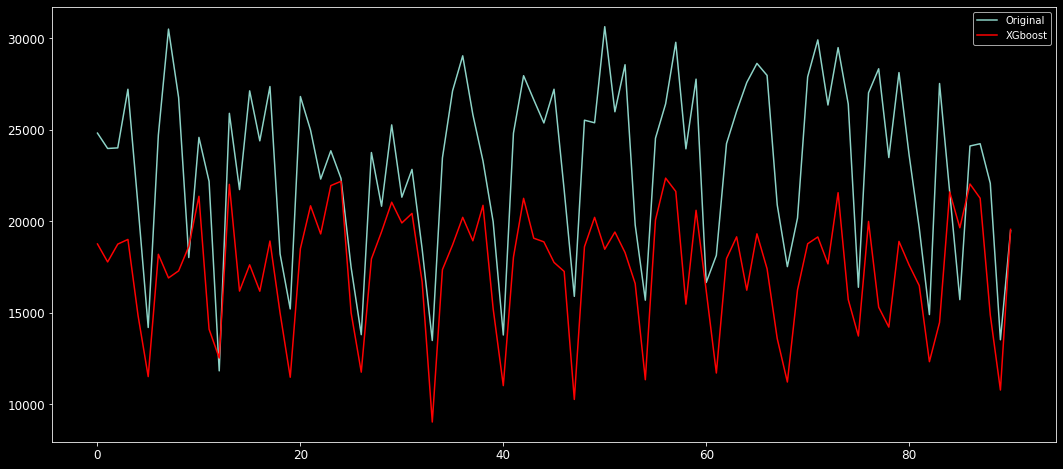

In [75]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat,color='red',label='XGboost')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

In [76]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train,y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test.payload, yhat)
predictionsDict['Lightgbm'] = yhat

[None, None, None, None]

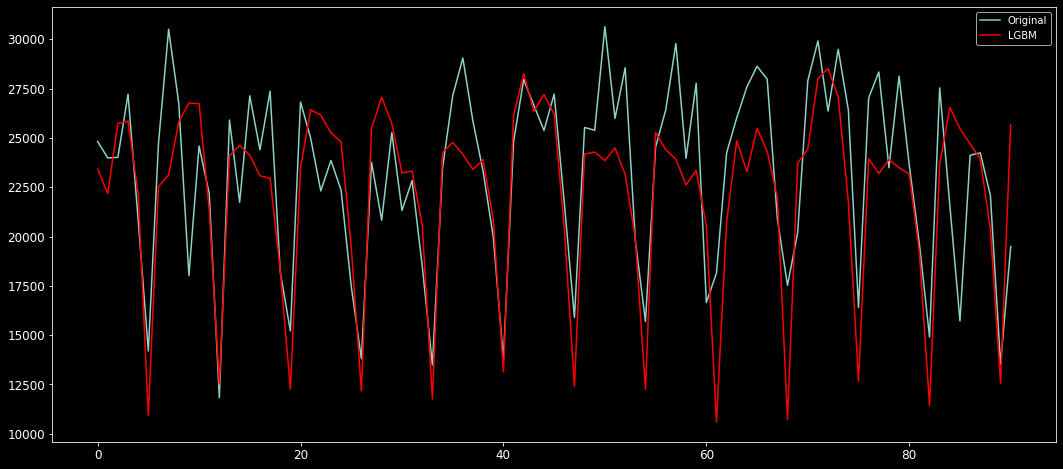

In [77]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat,color='red',label='LGBM')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

In [78]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Kneighbors'] = evaluate(df_test.payload, yhat)
predictionsDict['Kneighbors'] = yhat

[None, None, None, None]

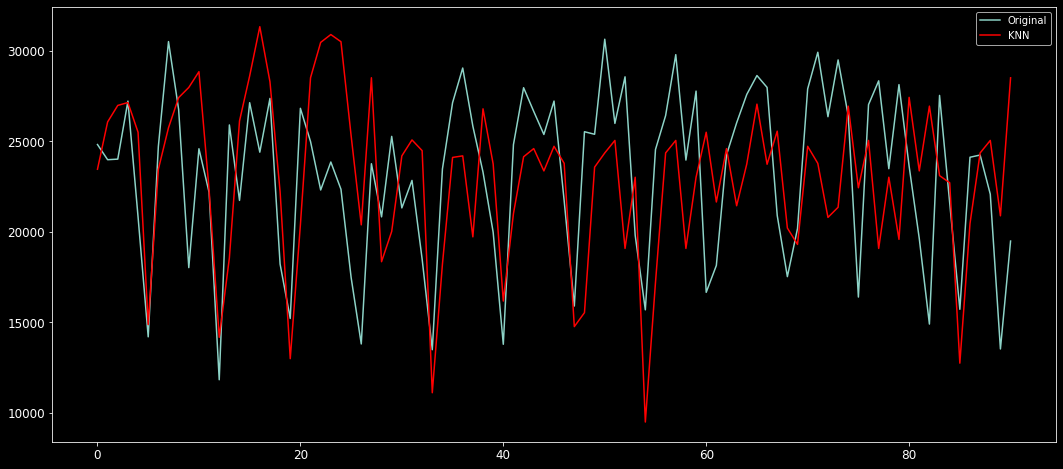

In [79]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat,color='red',label='KNN')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

In [80]:
prophet = Prophet(
    growth='linear', 
    seasonality_mode='multiplicative',
    daily_seasonality=True, 
    ).add_country_holidays(country_name='Indonesia')


for col in prophet_training.columns:
    if col not in ["ds", "y"]:
        prophet.add_regressor(col)

In [81]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet multivariate'] = evaluate(y_test, yhat.yhat.values)
predictionsDict['Prophet multivariate'] = yhat.yhat.values

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


[None, None, None, None]

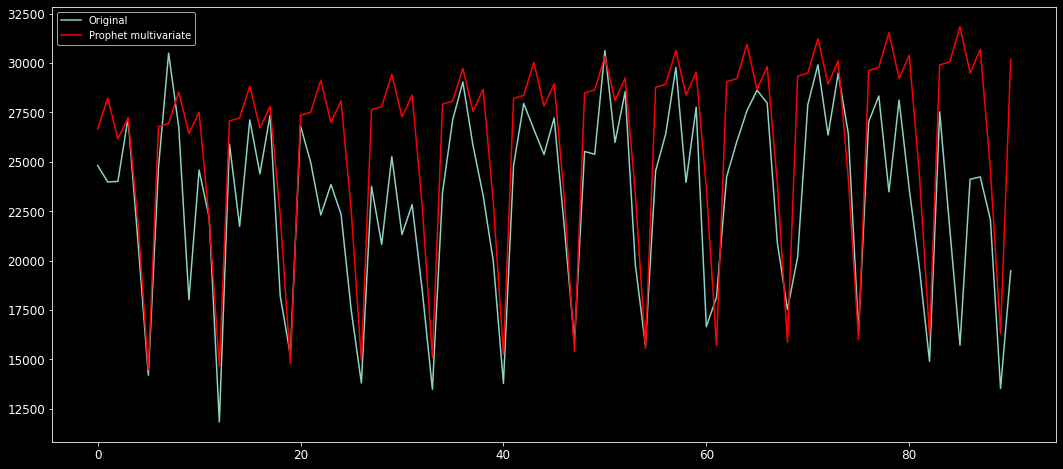

In [82]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat.yhat,color='red',label='Prophet multivariate')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

In [83]:
#For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24
def window_data(X,Y,window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x=[]
    y=[]
    for i in range(window-1,len(X)):
        x.append(X[i-window+1:i+1]) 
        y.append(Y[i])
    return np.array(x), np.array(y)
        
#Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w,y_w = window_data(X_w,y_w,window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

#Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [84]:
dropout=0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=X_train_w.shape[-2:],dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='rmsprop', loss='mae')

In [85]:
EVALUATION_INTERVAL = 200
EPOCHS = 5

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_data, validation_steps=50)#,callbacks=[tensorboard_callback]) #Uncomment this line for tensorboard support

Epoch 1/5
200/200 [==============================] - 4s 21ms/step - loss: 11993.2344 - val_loss: 4257.7407
Epoch 2/5
200/200 [==============================] - 4s 20ms/step - loss: 4836.5913 - val_loss: 3751.1970
Epoch 3/5
200/200 [==============================] - 4s 20ms/step - loss: 4201.9775 - val_loss: 4909.6396
Epoch 4/5
200/200 [==============================] - 4s 20ms/step - loss: 3463.4302 - val_loss: 5047.3452
Epoch 5/5
200/200 [==============================] - 4s 21ms/step - loss: 2672.9656 - val_loss: 3763.4316


In [86]:
yhat = simple_lstm_model.predict(X_test_w).reshape(1,-1)[0]
resultsDict['Tensorflow simple LSTM'] = evaluate(y_test,yhat)
predictionsDict['Tensorflow simple LSTM'] = yhat

[None, None, None, None]

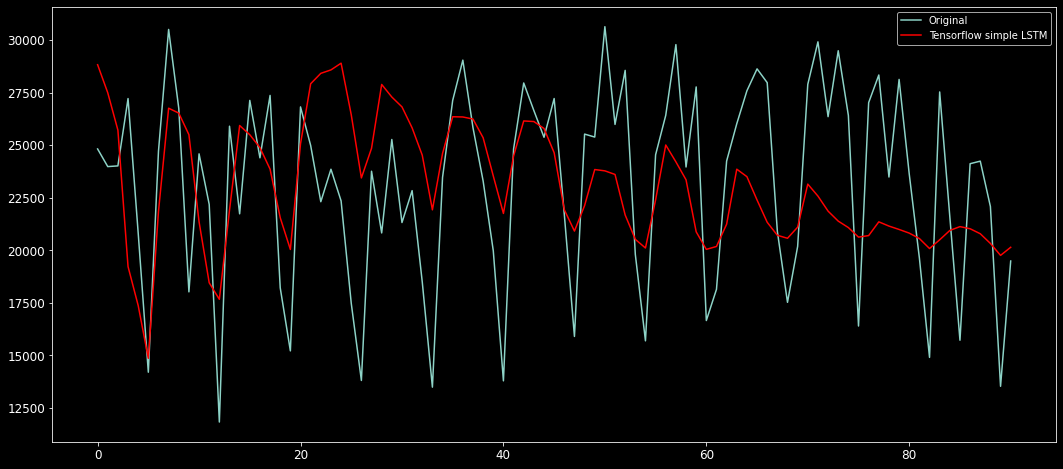

In [87]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat,color='red',label='Tensorflow simple LSTM')
legend = plt.legend()
plt.setp(legend.get_texts(), color='w')

In [88]:
import pickle

with open('results/scores.pickle', 'wb') as handle:
    pickle.dump(resultsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('results/predictions.pickle', 'wb') as handle:
    pickle.dump(predictionsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [89]:
import pickle
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

from metrics import evaluate
from plots import bar_metrics


warnings.filterwarnings("ignore") #We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8

with open('results/scores.pickle', 'rb') as handle:
    resultsDict = pickle.load(handle)

## Load our results from the model notebook
with open('results/predictions.pickle', 'rb') as handle:
    predictionsDict = pickle.load(handle)

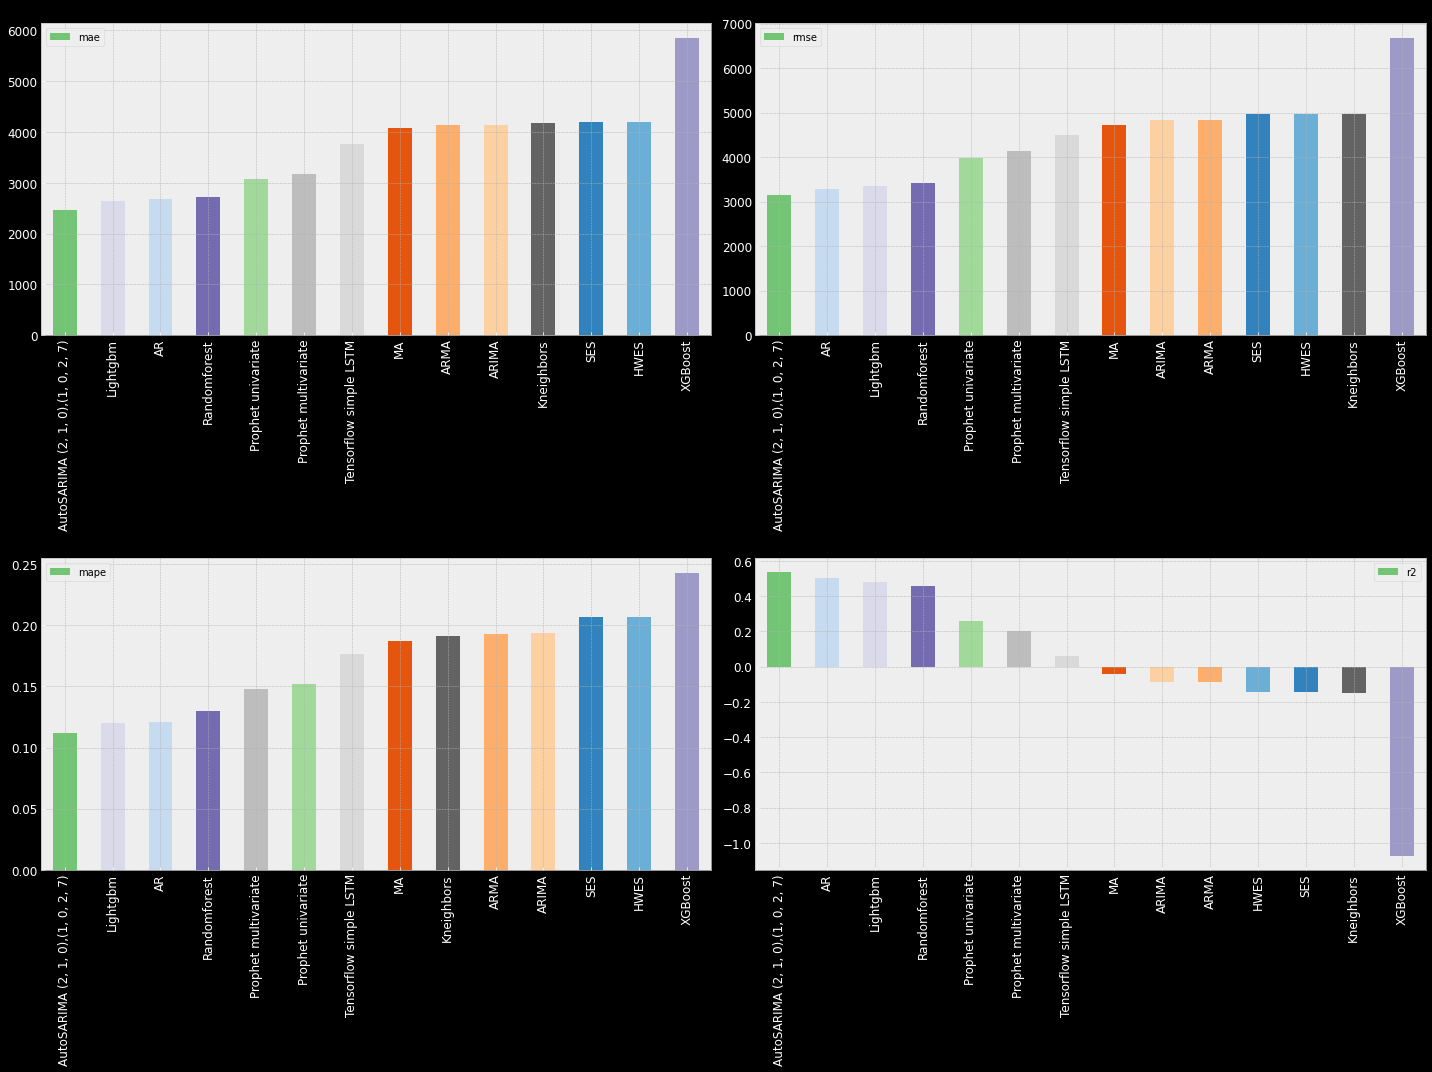

In [90]:
bar_metrics(resultsDict)

### Best Model : AutoSARIMA

We will be focusing more on SARIMA model

In [92]:
autoModel = pm.auto_arima(df_training.payload, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=7, stepwise=True)
autoModel.fit(dff_training.payload)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5569.962, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5370.395, Time=0.41 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5442.603, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5567.980, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=5552.763, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=5350.152, Time=0.94 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=5365.919, Time=1.26 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=5334.576, Time=0.92 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=5470.150, Time=0.09 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=5362.329, Time=1.24 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=5445.916, Time=0.20 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.66 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=5345.010, Time=0.69 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=5

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(1, 0, 2, 7),
      suppress_warnings=True, with_intercept=False)

In [93]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(dff_test.payload))):
    temp_train = df_tmp[:len(dff_training)+t]
    model = sm.tsa.statespace.SARIMAX(temp_train.payload, order=order, seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['AutoSARIMAX {0},{1}'.format(order,seasonalOrder)] = evaluate(df_test.payload, yhat.values)
predictionsDict['AutoSARIMAX {0},{1}'.format(order,seasonalOrder)] = yhat.values

100%|██████████| 91/91 [01:45<00:00,  1.16s/it]


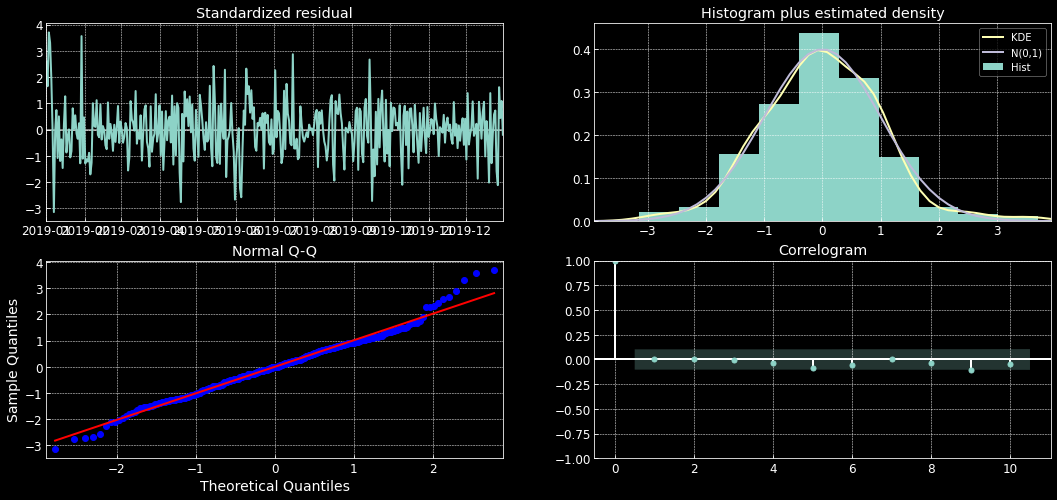

In [131]:
model_fit.plot_diagnostics()
plt.style.use('dark_background')
plt.show()

1. Residuals have relatively constant variance
2. model follows normal distribution
3. Model is fitted well
4. The residuals are not auto correlated as there is no significant pattern

In [95]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                payload   No. Observations:                  364
Model:             SARIMAX(2, 1, 0)x(1, 0, [1, 2], 7)   Log Likelihood               -3507.445
Date:                                Sun, 13 Dec 2020   AIC                           7026.891
Time:                                        00:13:55   BIC                           7050.257
Sample:                                    01-01-2019   HQIC                          7036.179
                                         - 12-30-2019                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3856      0.048     -8.062      0.000      -0.479      -0.292
ar.L2         -0.1189      0.049     -2.443      0.015      -0.214      -0.024
ar.S.L7        0.9923      0.005    204.549      0.000       0.983       1.002
ma.S.L7       -0.7117      0.052    -13.715      0.000      -0.813      -0.610
ma.S.L14      -0.1300      0.053     -2.461      0.014      -0.233      -0.026
sigma2      1.402e+07   5.03e-10   2.79e+16      0.000     1.4e+07     1.4e+07
===================================================================================
Ljung-Box (Q):                       38.94   Jarque-Bera (JB):                 2.33
Prob(Q):                              0.52   Prob(JB):                         0.31
Heteroskedasticity (H):               0.85   Skew:                            -0.03
Prob(H) (two-sided):                  0.39   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.23e+32. Standard errors may be unstable.
"""

The Ljung-Box (Q) test is done to confirm that the residuals are independent. This means that our errors are not correlated with each other and we’ve successfully accounted for patterns in the data with our model.

The hypothesis test we perform for Ljung-Box is as follows:

H0: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).

H1: The data are not independently distributed; they exhibit serial correlation.

Our p-value (Prob-Q) is greater than critical value (0.05) so we fail to reject the null hypothesis, the residuals are independent which indicates that the model provides an adequate fit to the data.


Heteroskedasticity: An assumption of Linear Regression is that there is no heteroskedasticity of residuals. This means that the variance of residuals should not increase with fitted values of response variable; we prefer our residuals to be homoskedastic.

H0: The variance of the residuals is constant; no Heteroskedasticity.

H1: Heteroskedasticity is present.

Here we fail to reject the null hypothesis at the 95% confidence level, since our p-value is 0.85. We can assume homoskedasticity in our residuals.

Jarque-Bera is the test of normality, whether our data is following normal distribution or no.

H0: The residuals is normally distributed

H1: The residuals is not normally distributed

Here we also fail to reject the null hypothesis as our Jarque-Bera test p-value is 0.31. We can assume our residuals are normally distributed

In [96]:
print('Mean Absolute Error on Train Data for SARIMAX: '+str(mean_absolute_error(y_test, yhat))+' KG')

Mean Absolute Error on Train Data for SARIMAX: 2456.272798137753 KG


In [97]:
mse = ((yhat - y_test) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {} KG'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 9987567.06
The Root Mean Squared Error is 3160.31 KG


Mean Absolute Error (MAE): This measures the absolute average distance between the real data and the predicted data, but it fails to punish large errors in prediction.

Mean Square Error (MSE): This measures the squared average distance between the real data and the predicted data. Here, larger errors are well noted (better than MAE). But the disadvantage is that it also squares up the units of data as well. So, evaluation with different units is not at all justified.

Root Mean Squared Error (RMSE): This is actually the square root of MSE. Also, this metrics solves the problem of squaring the units.

[None, None, None, None]

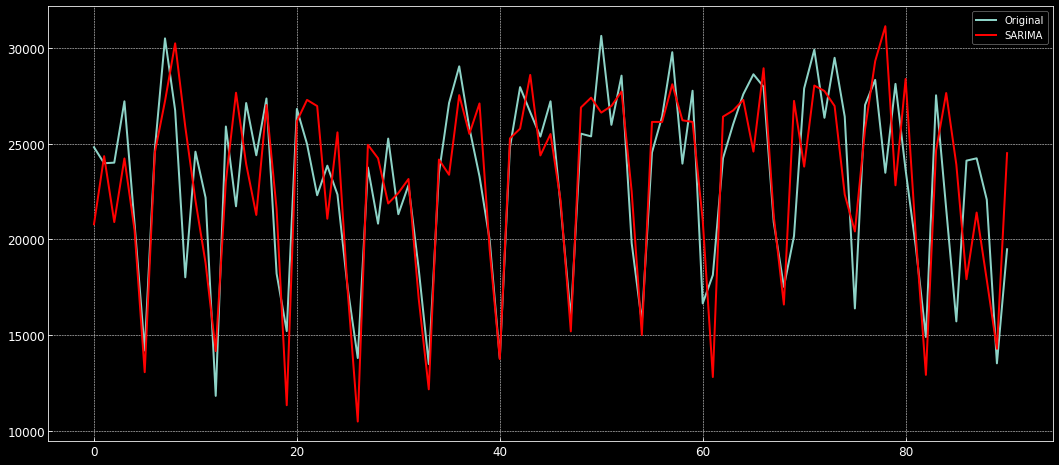

In [132]:
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat.values,color='red',label='SARIMA')
legend = plt.legend()
plt.setp(legend.get_texts(), color='white')

In [99]:
df_predict = pd.DataFrame(data=yhat)

In [100]:
df_predict.index.names = ['flown_date']

In [101]:
df_predict = df_predict.rename(columns={0: 'payload'})

In [102]:
df_predict

payload
flown_date              
2019-10-02  20155.205207
2019-10-03  24221.167129
2019-10-04  20367.138162
2019-10-05  25017.439574
2019-10-06  20657.945089
...                  ...
2019-12-27  18156.469790
2019-12-28  21110.672194
2019-12-29  17725.999453
2019-12-30  16009.155842
2019-12-31  24303.218745

[91 rows x 1 columns]

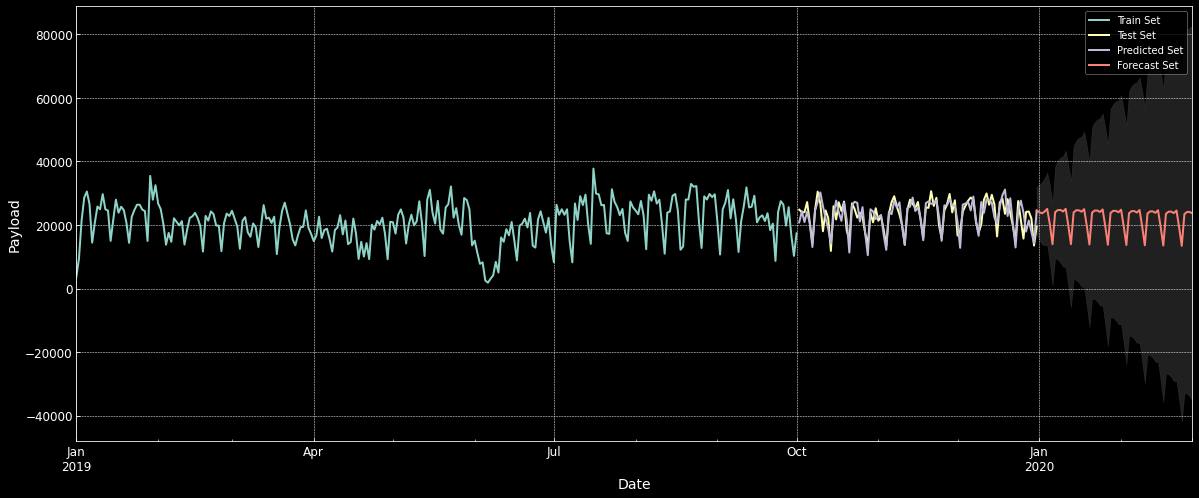

In [133]:
pred_uc = model_fit.get_forecast(steps=60)
pred_ci = pred_uc.conf_int()
ax = df_training.payload.plot(label='Train Set', figsize=(20, 8))
ax2 = df_test.payload.plot(label='Test Set', figsize=(20, 8))
ax3 = df_predict.payload.plot(label='Predicted Set', figsize=(20, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast Set')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='grey', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Payload')
plt.legend()
plt.show()

### Adding Holidays

In [104]:
df_holiday = pd.read_csv('holiday.csv')

In [105]:
df_holiday

Unnamed: 0        date  holiday
0             0  2019-01-01        1
1             1  2019-01-02        0
2             2  2019-01-03        0
3             3  2019-01-04        0
4             4  2019-01-05        0
..          ...         ...      ...
360         360  2019-12-27        0
361         361  2019-12-28        0
362         362  2019-12-29        0
363         363  2019-12-30        0
364         364  2019-12-31        0

[365 rows x 3 columns]

In [106]:
df_holiday = df_holiday.drop(['Unnamed: 0'], axis=1)

In [107]:
df_holiday['date'] = pd.to_datetime(df_holiday['date'])

In [108]:
df_holiday = df_holiday.groupby('date', as_index=True).sum()

In [109]:
df_holiday

holiday
date               
2019-01-01        1
2019-01-02        0
2019-01-03        0
2019-01-04        0
2019-01-05        0
...             ...
2019-12-27        0
2019-12-28        0
2019-12-29        0
2019-12-30        0
2019-12-31        0

[365 rows x 1 columns]

In [113]:
split_date ='2019-10-01'
df_holiday_training = df_holiday.loc[df_holiday.index <= split_date]
df_holiday_test = df_holiday.loc[df_holiday.index > split_date]
print(f"{len(df_holiday_training)} days of training data \n {len(df_holiday_test)} days of testing data ")

274 days of training data 
 91 days of testing data 


In [115]:
autoModel = pm.auto_arima(df_training.payload, 
                          trace=True, 
                          error_action='ignore', 
                          suppress_warnings=True, 
                          seasonal=True,
                          m=7, 
                          stepwise=True,
                         exogenous=df_holiday_training[['holiday']])
autoModel.fit(dff_training.payload)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5571.346, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5375.940, Time=0.59 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5446.764, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=6828.751, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=5555.274, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=5356.518, Time=1.00 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=5372.352, Time=1.61 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=5333.592, Time=0.90 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=5473.001, Time=0.11 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=5366.982, Time=1.47 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=5450.131, Time=0.27 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=5400.188, Time=1.62 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=5348.340, Time=0.81 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : 

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(1, 0, 2, 7),
      suppress_warnings=True, with_intercept=False)

In [116]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(dff_test.payload))):
    temp_train = df_tmp[:len(dff_training)+t]
    model = sm.tsa.statespace.SARIMAX(temp_train.payload, 
                                      order=order, 
                                      seasonal_order=seasonalOrder, 
                                      exogenous=df_holiday[['holiday']], 
                                      initialization='approximate_diffuse')
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['AutoSARIMAX {0},{1}'.format(order,seasonalOrder)] = evaluate(df_test.payload, yhat.values)
predictionsDict['AutoSARIMAX {0},{1}'.format(order,seasonalOrder)] = yhat.values

100%|██████████| 91/91 [01:47<00:00,  1.18s/it]


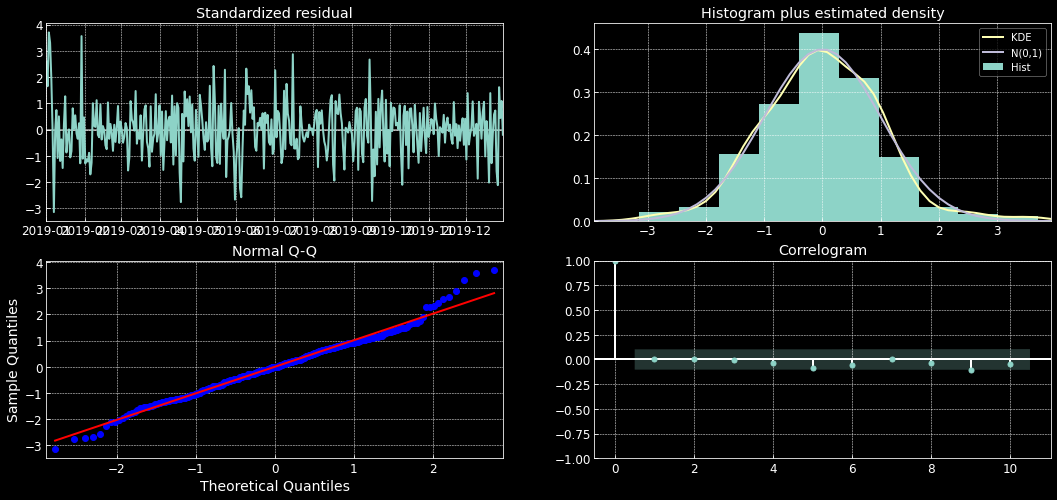

In [134]:
model_fit.plot_diagnostics()
plt.show()

In [118]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                payload   No. Observations:                  364
Model:             SARIMAX(3, 1, 0)x(1, 0, [1, 2], 7)   Log Likelihood               -3519.514
Date:                                Sun, 13 Dec 2020   AIC                           7053.028
Time:                                        00:19:16   BIC                           7080.308
Sample:                                    01-01-2019   HQIC                          7063.870
                                         - 12-30-2019                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3836      0.042     -9.078      0.000      -0.466      -0.301
ar.L2         -0.1625      0.048     -3.361      0.001      -0.257      -0.068
ar.L3         -0.1444      0.053     -2.734      0.006      -0.248      -0.041
ar.S.L7        1.0000      0.010    100.729      0.000       0.981       1.019
ma.S.L7       -0.7243      0.053    -13.620      0.000      -0.829      -0.620
ma.S.L14      -0.1299      0.058     -2.236      0.025      -0.244      -0.016
sigma2      1.425e+07   7.78e-10   1.83e+16      0.000    1.43e+07    1.43e+07
===================================================================================
Ljung-Box (Q):                       27.25   Jarque-Bera (JB):                15.56
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.19
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.53e+30. Standard errors may be unstable.
"""

In [119]:
print('Mean Absolute Error on Train Data for SARIMAX: '+str(mean_absolute_error(y_test, yhat))+' KG')

Mean Absolute Error on Train Data for SARIMAX: 2514.920586977744 KG


In [120]:
mse = ((yhat - y_test) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {} KG'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 10006837.49
The Root Mean Squared Error is 3163.36 KG


[None, None, None, None]

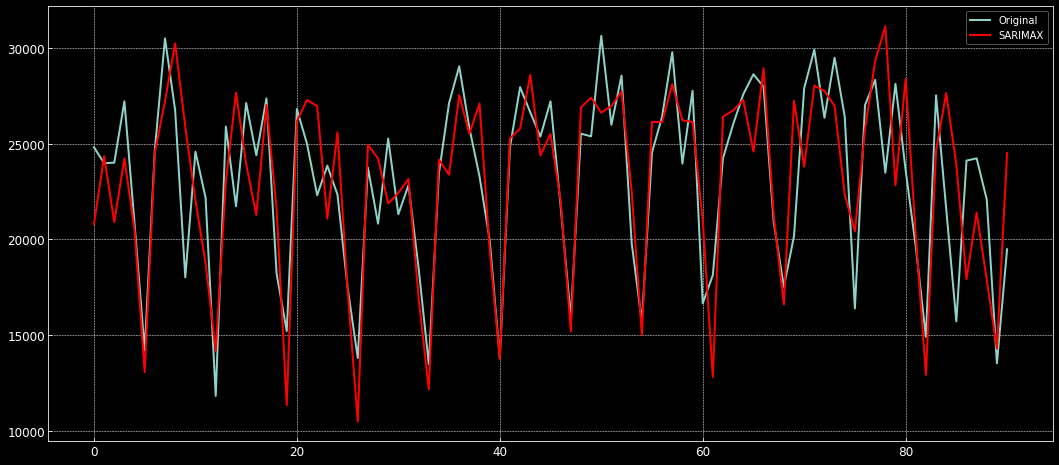

In [135]:
plt.style.use('dark_background')
plt.plot(df_test.payload.values , label='Original')
plt.plot(yhat.values,color='red',label='SARIMAX')
legend = plt.legend()
plt.setp(legend.get_texts(), color='white')

In [122]:
df_predict = pd.DataFrame(data=yhat)

In [123]:
df_predict.index.names = ['flown_date']

In [124]:
df_predict = df_predict.rename(columns={0: 'payload'})

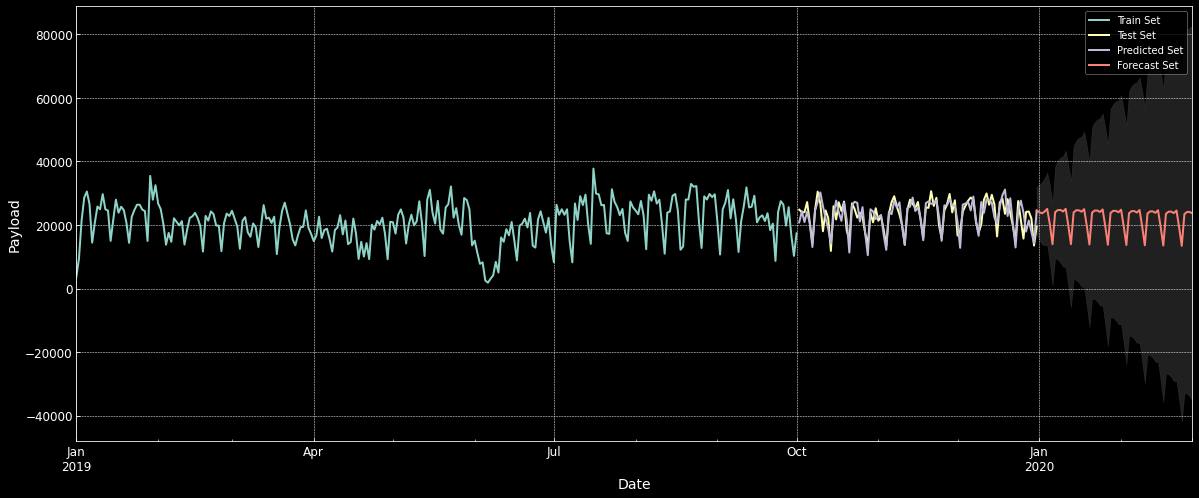

In [130]:
plt.style.use('dark_background')
pred_uc = model_fit.get_forecast(steps=60)
pred_ci = pred_uc.conf_int()
ax = df_training.payload.plot(label='Train Set', figsize=(20, 8))
ax2 = df_test.payload.plot(label='Test Set', figsize=(20, 8))
ax3 = df_predict.payload.plot(label='Predicted Set', figsize=(20, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast Set')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='grey', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Payload')
plt.legend()
plt.show()